In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import argparse
from node2vec import Node2Vec
import itertools
import plotly.graph_objs as go

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_dimacs_cnf(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("c"):
                continue
            if line.startswith("p cnf"):
                num_vars, num_clauses = map(int, line.strip().split()[2:])
            else:
                clause = list(map(int, line.strip().split()[:-1]))
                clauses.append(clause)
    return num_vars, clauses

def visualize_graph(clauses):
    G = nx.Graph()
    for clause in clauses:
        for literal in clause:
            G.add_node(abs(literal))  # Dodanie węzłów dla zmiennych
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))  # Dodanie krawędzi między zmiennymi w tej samej klauzuli
    pos = nx.spring_layout(G)  # Ustalenie układu wizualizacji
    nx.draw(G, pos, with_labels=True, node_size=500)
    plt.show()

def generate_node_embeddings(clauses):
    G = nx.Graph()
    for clause in clauses:
        for literal in clause:
            G.add_node(abs(literal))
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))

    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model, G

In [12]:
def utworzSkierowanyGraf(G1, model_2):
    G2 = nx.DiGraph()
    for i in G1.nodes:
        node, waga = model_2.wv.most_similar(f'{i}')[0]
        # print(i, int(node), round(waga,2))
        G2.add_edge(i, int(node))  # Dodanie krawędzi z wagą 5
    # G2.add_edge(2, 3, weight=3)  # Dodanie krawędzi z wagą 3
    # G2.add_edge(3, 4, weight=7)  # Dodanie krawędzi z wagą 7

    # Rysowanie grafu
    # pos = nx.shell_layout(G2)
    pos = nx.spring_layout(G2, scale=10)
    # pos = nx.kamada_kawai_layout(G2)
    nx.draw(G2, pos, with_labels=True, node_size=150, arrowsize=20)
    # Dodanie etykiet krawędzi
    labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, edge_labels=labels)
    plt.show()
    return G2, pos

In [6]:
# nazwa = "DIMACS_files/easy/sat/Analiza1-itox_vc1033.cnf"
# cala_operacja(nazwa)

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Computing transition probabilities: 100%|██████████| 100/100 [00:00<00:00, 1030.92it/s]


KeyboardInterrupt: 

In [ ]:
# nazwa = "DIMACS_files/medium/unsat/Analiza1-AProVE07-08.cnf"
# cala_operacja(nazwa)

In [10]:
# def interactive_directed_graph(G, pos):
#     edge_trace = go.Scatter(
#         x=[],
#         y=[],
#         line=dict(width=0.5, color='#888'),
#         hoverinfo='none',
#         mode='lines')

#     for edge in G.edges():
#         x0, y0 = pos[edge[0]]
#         x1, y1 = pos[edge[1]]
#         edge_trace['x'] += (x0, x1, None)
#         edge_trace['y'] += (y0, y1, None)

#     node_trace = go.Scatter(
#         x=[],
#         y=[],
#         text=[],
#         mode='markers+text',
#         hoverinfo='text',
#         marker=dict(
#             colorscale='Blues',
#             reversescale=False,
#             color=[],
#             size=10,
#             colorbar=dict(
#                 thickness=15,
#                 title='Stopień węzła',
#                 xanchor='left',
#                 titleside='right'
#             ),
#             line=dict(width=2)))

#     for node in G.nodes():
#         x, y = pos[node]
#         node_trace['x'] += (x,)
#         node_trace['y'] += (y,)
#         node_trace['text'] += ('Var: ' + str(node),)

#     for node, adjacencies in enumerate(G.adjacency()):
#         node_trace['marker']['color'] += (len(adjacencies[1]),)

#     layout = go.Layout(
#         titlefont=dict(size=16),
#         showlegend=False,
#         hovermode='closest',
#         margin=dict(b=5, l=5, r=5, t=5),
#         annotations=[dict(
#             text="",
#             showarrow=False,
#             xref="paper", yref="paper")],
#         xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#         yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

#     fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
#     fig.show()


In [21]:
def interactive_directed_graph(G, pos):
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines',
        marker=dict(
            showscale=False,
            colorscale='Blues',
            reversescale=True,
            color=[],
            size=5,
            colorbar=dict(
                thickness=15,
                title='Weight',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)))

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += (x0, x1, None)
        edge_trace['y'] += (y0, y1, None)

    # Dodanie strzałek na krawędziach skierowanych
    arrows = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        arrows.append(go.Scatter(x=[x0, x1, None], y=[y0, y1, None],
                                 mode='lines',
                                 line=dict(color='black', width=1),
                                 hoverinfo='none',
                                 showlegend=False))

    arrow_annotations = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        arrow_annotations.append(
            dict(
                x=x1, y=y1,
                xref='x', yref='y',
                showarrow=True,
                arrowhead=3,
                arrowsize=1,
                arrowwidth=1,
                arrowcolor='black',
                ax=x0, ay=y0
            )
        )

    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            colorscale='Blues',
            reversescale=False,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Degree',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)))

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += (x,)
        node_trace['y'] += (y,)
        node_trace['text'] += ('Var: ' + str(node),)

    for node, adjacencies in enumerate(G.adjacency()):
        node_trace['marker']['color'] += (len(adjacencies[1]),)

    layout = go.Layout(
        titlefont=dict(size=16),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=5, l=5, r=5, t=5),
        annotations=[dict(
            text="",
            showarrow=False,
            xref="paper", yref="paper")],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    fig.show()


Computing transition probabilities: 100%|██████████| 100/100 [00:00<00:00, 836.84it/s]

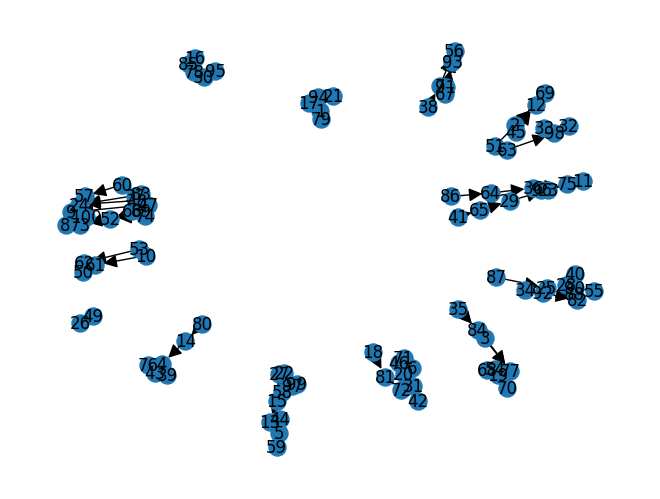

In [22]:
def cala_operacja(nazwa_pliku):
    num_vars, clauses = read_dimacs_cnf(nazwa_pliku)
    model, G = generate_node_embeddings(clauses)
    G2, pos = utworzSkierowanyGraf(G, model)
    interactive_directed_graph(G2, pos)
    return num_vars, clauses

nazwa = "DIMACS_files/turbo_easy/example_2.cnf"
num_vars, clauses = cala_operacja(nazwa)
